# Determination of the best neural network for VBS analysis

In questo notebook proponiamo la ricerca della miglior configurazione di una rete neurale nel caso della componente z del quadrimomento in processi di scattering tra bosoni vettore semileptonici.

##	Ricordiamo che il dataset è suddiviso nel seguente modo:
	lepton flavour (1 electron, 0 muon) | E_l | px_l | py_l | pz_l | MET | MET_phi saved in 'ewk_signal_withreco_withdelta_input.py'
	massW | E_nu | px_nu| py_nu | pz_nu saved in 'ewk_signal_withreco_withdelta_truth.py'

## Importazione e versioni delle librerie usate.

In [167]:
import numpy
print('numpy:', numpy.__version__)

import scipy
print('scipy:', scipy.__version__)

import matplotlib
print('matplotlib:', matplotlib.__version__)

import IPython
print('iPython:', IPython.__version__)

import sklearn
print('scikit-learn:', sklearn.__version__)

import tensorflow
print('tensorflow:', tensorflow.__version__)

import keras
print('keras:', keras.__version__) 

numpy: 1.15.4
scipy: 1.1.0
matplotlib: 3.0.1
iPython: 7.2.0
scikit-learn: 0.20.1
tensorflow: 1.12.0
keras: 2.2.4


In [204]:
import pylab as pl
import numpy as np  
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import scipy.odr as odr 
from keras.activations import relu
from keras.activations import tanh
import matplotlib.pyplot as plt 
import matplotlib as mp
import itertools
import random
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from array import array
from sklearn import metrics
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn import svm, datasets
from scipy import interp
from keras.callbacks import History 
history = History()
from keras.callbacks import *
from sklearn.externals import joblib
from scipy.stats import norm
import scipy.stats
from keras.models import Sequential, load_model
from keras.activations import relu
from keras.layers import Dense, LeakyReLU, Dropout
from keras.optimizers import Adam, SGD
from keras import metrics
from keras import losses

## Importazione del dataset sottoforma di numpy array

In [169]:
ewk_input = np.load('ewk_signal_withreco_withdelta_input.npy')
ewk_truth = np.load('ewk_signal_withreco_withdelta_truth.npy')

Dividiamo il dataset in training set, validation set e test set, vediamo inotlre se i dati sono stati importati in maniera corretta.

In [170]:
ewk_input_train = ewk_input[0:400000,:]
ewk_truth_train = ewk_truth[0:400000,4].reshape(-1, 1)

ewk_input_validation = ewk_input[400000:450000,:]
ewk_truth_validation = ewk_truth[400000:450000,4].reshape(-1, 1)

print(ewk_input[0,:])
print(ewk_input.shape)
print(ewk_truth.shape)

ewk_input_test = ewk_input[450000:501328,:]
ewk_truth_test = ewk_truth[450000:501328,4].reshape(-1, 1)

[  0.          57.0622945  -54.51616779  16.01704417   5.24854253
 102.68898411   3.92143733]
(501328, 7)
(501328, 10)


Z-scaliamo il dataset in modo da ottenere dati più maneggiabili poichè sono più vicini allo 0.
Z-scalare vuol dire fare la seguente cosa:
$ data_{new} = \frac{data_{old}-\mu}{\sigma} $
Salviamo successivamente il modello scalato in un file 'scaler_input.pkl' in modo da poterlo richiamare successivamente

In [171]:
scaler_input = StandardScaler()
scaler_truth = StandardScaler()


scaler_input.fit(ewk_input_train)
scaler_truth.fit(ewk_truth_train)

input_train = scaler_input.transform(ewk_input_train)
truth_train = scaler_truth.transform(ewk_truth_train)
input_validation = scaler_input.transform(ewk_input_validation)
truth_validation = scaler_truth.transform(ewk_truth_validation)
input_test = scaler_input.transform(ewk_input_test)
truth_test = ewk_truth_test

print(input_test[0,:])

[ 0.          0.23106666 -0.56414794 -0.98000085  0.91218928 -0.36788357
  1.2257837 ]


In [172]:
joblib.dump(scaler_input,  "scaler_input.pkl")
joblib.dump(scaler_truth,  "scaler_truth.pkl")

['scaler_truth.pkl']

## Importiamo ora il modello da provare nella nostra rete neurale:

Definiamo il decay_rate, il learning_rate e il numero di epochs e la patience, definiamo inoltre la directory in cui salvare i dati in modo da non doverla cambiare ogni volta, se devi salvare i dati basta che vai da terminale, entri nella cartella in cui vuoi salvare i dati, lanci il comando 'pwd' e copi in 'output_dir' la stringa che ottieni:

In [173]:
decay_rate = 0
learning_rate = 1e-4
epoch = 100
patience = "0.001:50"
initial_epochs = 0
batch_size = 128
output_dir = "/home/christian/Scrivania/notebook/VBS analysis/risultati_predizioni/grid_search"
comparison_dir = "/home/christian/Scrivania/notebook/VBS analysis/risultati_predizioni"

Definiamo la rete neurale:

In [205]:
model = Sequential()

model.add(Dense(units=1000, input_dim=input_validation.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1000,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1))
        
model.compile(loss=losses.mean_squared_error,
              optimizer='adam',
              metrics=[metrics.mean_absolute_error])

Completo la procedura di training. Abbiamo inserito inoltre un algoritmo di early stopping in modo tale che la rete smetta di essere allenata quando la loss function non decresce di un valore prefissato ogni numero prefissato di epoch (**patience**).

In [194]:
auto_save = ModelCheckpoint(output_dir + "/current_model", monitor='val_loss',
                    verbose=1, save_best_only=True, save_weights_only=False,
                    mode='auto', period=2)

min_delta = float(patience.split(":")[0])
p_epochs = int(patience.split(":")[1])
early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta,
                               patience=p_epochs, verbose=1)

def reduceLR (epoch):
    return learning_rate * (1 / (1 + epoch*decay_rate))

lr_sched = LearningRateScheduler(reduceLR, verbose=1)
csv_logger = CSVLogger(output_dir + '/training.log')


print(">>> Training...")
W_val = np.ones(input_validation.shape[0])
history = model.fit(input_train, truth_train,
                        validation_data = (input_validation, truth_validation),
                        epochs=epoch, initial_epoch=initial_epochs,
                        batch_size=batch_size, shuffle=True,
                        callbacks=[auto_save, early_stop, lr_sched, csv_logger])

>>> Training...


RuntimeError: You must compile your model before using it.

Passiamo ora alla fase di test, facciamo agire la nostra rete neurale con i pesi trovati in precedenza per fare predizioni sul nostro dataset, Z-scaliamo inoltre i dati al contrario per avere i valori reali e non vicini allo 0.

In [145]:
predictions = model.predict(input_test,batch_size=2048)
predictions = np.concatenate(predictions)
predictions = scaler_truth.inverse_transform(predictions)

Facciamo ora qualche plot utile per visualizzare i dati, nel primo caso si tratta di uno scatter plot in cui i dati predetti vengono comparati con quelli reali, nel secondo caso è sempre uno scatter plot 2D in cui al posto dei pallini usiamo i colori per diversificare il numero di conteggi:

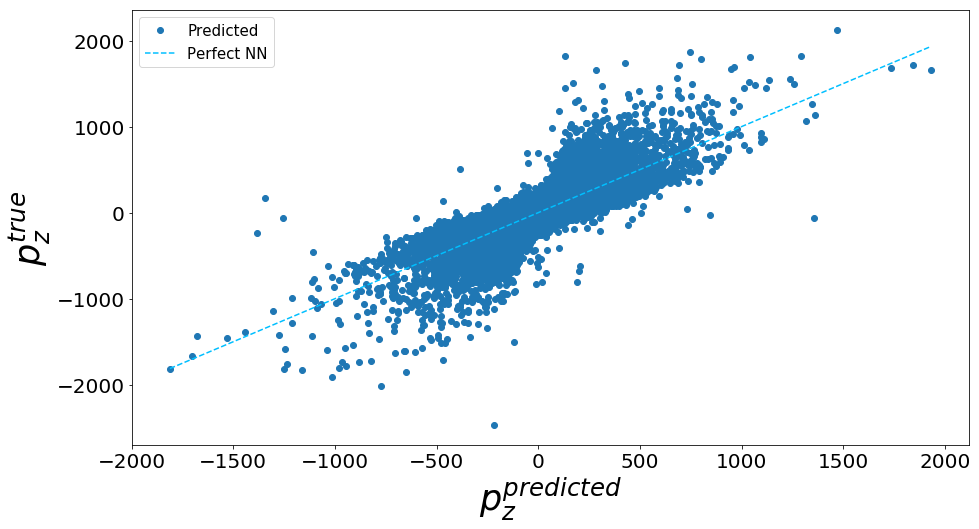

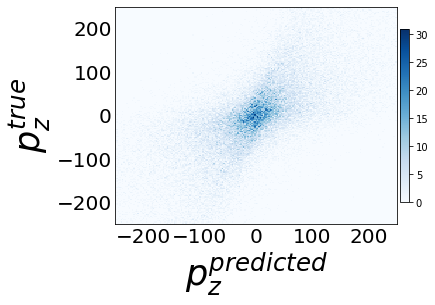

In [146]:
def scatter_plotter(pred, y):
    fig = plt.figure(figsize=(15,8))
    plt.plot(pred,y, 'o', label = "Predicted")
    top = max(pred)
    bottom = min(pred)
    plt.plot([bottom,top],[bottom,top], "r--", color = "deepskyblue", label = "Perfect NN")
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel(r'$p_{z}^{predicted}$', size = 35) 
    plt.ylabel(r'$p_{z}^{true}$', size = 35) 
    plt.legend(loc="best", prop={'size': 15})
    plt.show()
    plt.ioff()
    fig.savefig(output_dir+'/scatter_plot.png', bbox_inches='tight')
    
def plot_2d_hist_1(y, pred):  
    fig = plt.figure()
    ax = fig.add_subplot(111)

    H = ax.hist2d(y, pred, bins=200, range = [[-250,250],[-250,250]] , cmap = "Blues")

    fig.colorbar(H[3], ax=ax, shrink=0.8, pad=0.01, orientation="vertical")
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel(r'$p_{z}^{predicted}$', size = 35) 
    plt.ylabel(r'$p_{z}^{true}$', size = 35) 
    plt.show()
    fig.savefig(output_dir+'/predictions_histogram2d_plot.pdf', bbox_inches='tight')

    
scatter_plotter(predictions, np.concatenate(truth_test))
plot_2d_hist_1(predictions, np.concatenate(truth_test))

Disegniamo inoltre la loss function:

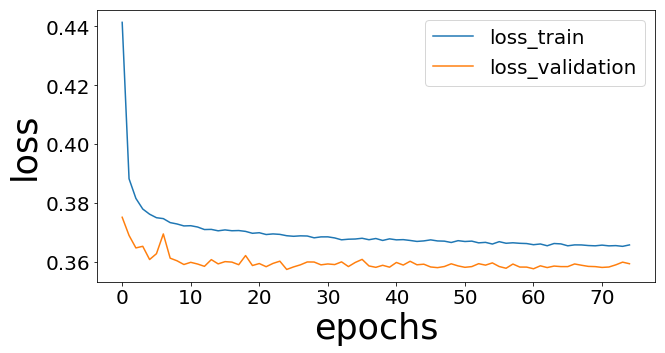

In [154]:
def loss_plotter(history):
    fig = plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label = "train_loss")
    plt.plot(history.history['val_loss'], label="val_loss")
    plt.legend(['loss_train', 'loss_validation'], loc='upper right', fontsize = 20)
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel('epochs', size = 35)
    plt.ylabel('loss', size = 35)
    plt.show()
    fig.savefig(output_dir+ '/loss_plot.pdf', bbox_inches='tight')
    
loss_plotter(history)

Salviamo ora i dati in un file esterno in modo da poterli richiamare successivamente per fare dei confronti:

In [148]:
np.savetxt(output_dir + "/predictions.txt" , predictions)

print(">>>>>>>>> SAVING HYPERPARAMETERS >>>>>>>>")
f = open(output_dir + "/configs.txt", "w")
f.write("epochs: {0}\n".format(epoch))
f.write("batch_size: {0}\n".format(batch_size))
f.write("learning_rate: {0}\n".format(learning_rate))
f.write("decay_rate: {0}\n".format(decay_rate))
f.write("patience: {0}\n".format(patience))
f.close()


>>>>>>>>> SAVING HYPERPARAMETERS >>>>>>>>


# Calcolo della rete migliore
Passiamo ora al calcolo della rete migliore, in particolare, dopo aver provato diverse configurazioni confrontiamo le loss function e le predizioni.
Per prima cosa ci occupiamo quindi di ottimizzare il numero di hidden layer e successivamente ottimiziamo il numero di neuroni per layer supponendo che questi due iperparametri siano indipendenti. Successivamente ci occuperemo di ottimizzare il learning rate, la batch size e il numero di epoch. Come parametro oggettivo per confrontare le diverse configurazioni utilizziamo la loss function ossia la funzione che quantifica quando le predizioni della rete neurale si discostino dai valori veri.

## Ottimizzazione numero di layer
Definiamo per prima cosa il plot della loss function, facciamo sì che il codice prenda i dati già calcolati in precedenza salvati nel file 'training.log' e disegnamole per vedere quale è la configurazione con il valore più basso. In questo caso si sono confrontate reti neurali con stesso numero di neuroni per layer ma con diverso numero di layer.

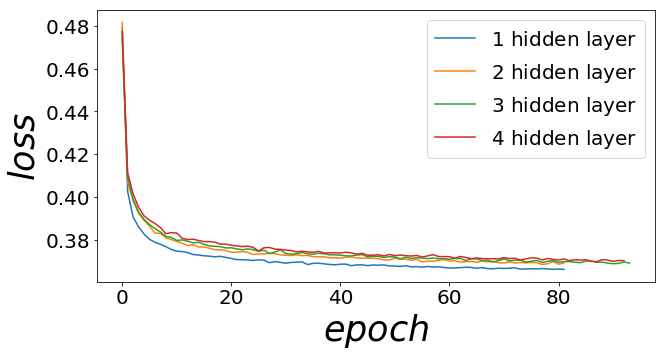

In [179]:
def loss_comparison_layer(loss_1,loss_2,loss_3,loss_4):
    fig = plt.figure(figsize=(10,5)) 
    ax = fig.add_subplot(111)
    plt.plot(d10["loss"], label=  r'$ 1 $' ' hidden layer')
    plt.plot(d11["loss"], label=  r'$ 2 $' ' hidden layer' )
    plt.plot(d12["loss"], label=  r'$ 3 $' ' hidden layer')
    plt.plot(d13["loss"], label=  r'$ 4 $' ' hidden layer' )
    plt.legend(fontsize = 20)
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel(r'$epoch$', size = 35)
    plt.ylabel(r'$loss$', size = 35)
    plt.show()
    fig.savefig(comparison_dir + '/loss_function_layer_comparison.pdf', bbox_inches='tight', dpi = 50)

d10 = pd.read_csv(comparison_dir + "/400_neurons_1_hiddenlayer/training.log")
d11 = pd.read_csv(comparison_dir + "/400_neurons_2_hiddenlayer/training.log")
d12 = pd.read_csv(comparison_dir + "/400_neurons_3_hiddenlayer/training.log")
d13 = pd.read_csv(comparison_dir + "/400_neurons_4_hiddenlayer/training.log")

loss_comparison_layer(d10,d11,d12,d13)

## Ottimizzazione numero di neuroni per layer
Definiamo per prima cosa il plot della loss function, facciamo sì che il codice prenda i dati già calcolati in precedenza salvati nel file 'training.log' e disegnamole per vedere quale è la configurazione con il valore più basso. In questo caso si è deciso di utilizzare una rete con lo stesso numero di layer ma con diverso numero di neuroni per layer. Notiamo quindi che la loss function decresce con l'aumentare con il numero di neuroni, decidiamo quindi di utilizzare una rete a 1000 neuroni.

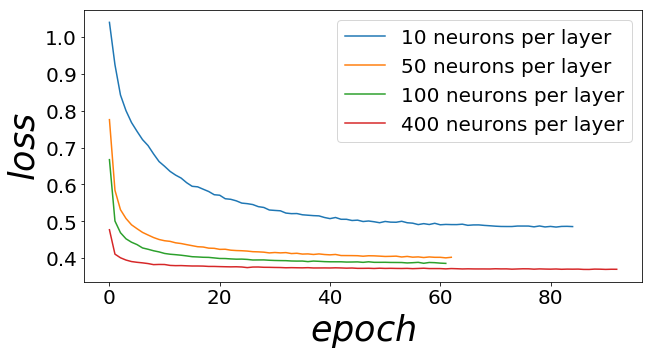

In [180]:
def loss_comparison_neurons(loss_4,loss_5, loss_6,loss_7):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    plt.plot(d4["loss"], label= '10 neurons per layer')
    plt.plot(d5["loss"], label= '50 neurons per layer')
    plt.plot(d6["loss"], label= '100 neurons per layer')
    plt.plot(d7["loss"], label= '400 neurons per layer')
    plt.legend(fontsize = 20)
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel(r'$epoch$', size = 35)
    plt.ylabel(r'$loss$', size = 35)
    plt.show()	
    fig.savefig(comparison_dir + '/loss_function_neurons_comparison.pdf', bbox_inches='tight', dpi = 50)
    
d4 = pd.read_csv(comparison_dir + "/10_neurons_4_hiddenlayer/training.log")
d5 = pd.read_csv(comparison_dir + "/50_neurons_4_hiddenlayer/training.log")
d6 = pd.read_csv(comparison_dir + "/100_neurons_4_hiddenlayer/training.log")
d7 = pd.read_csv(comparison_dir + "/400_neurons_4_hiddenlayer/training.log")


loss_comparison_neurons(d4,d5,d6,d7)

## Ottimizzazione learning rate
Definiamo per prima cosa il plot della loss function, facciamo sì che il codice prenda i dati già calcolati in precedenza salvati nel file 'training.log' e disegnamole per vedere quale è la configurazione con il valore più basso. In questo caso si è deciso di utilizzare una rete con lo stesso numero di layer con stesso numero di neuroni per layer ma con diverso learning rate. Ricordiamo che il learning rate è il coefficiente moltiplicativo del gradiente durante la correzione dei pesi delle variabili durante gli algoritmi di gradient descent, in cui i pesi dati alle variabili vengono corretti in direzione opposta ai loro gradienti.

In [ ]:
def loss_comparison_learning_rate(loss_1, loss_2, loss_3):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    plt.plot(d1["loss"], label= 'learning rate' r'$ = 2 * 10^{-4}$')
    plt.plot(d2["loss"], label= 'learning rate' r'$ = 6 * 10^{-4}$')
    plt.plot(d3["loss"], label= 'learning rate' r'$ = 8 * 10^{-4}$')
    plt.legend(fontsize = 20)
    plt.xticks( fontsize = 20)
    plt.yticks( fontsize = 20)
    plt.xlabel(r'$epoch$', size = 35)
    plt.ylabel(r'$loss$', size = 35)
    plt.show()	
    fig.savefig(comparison_dir + '/loss_function_learning_rate_comparison.pdf', bbox_inches='tight', dpi = 50)
    

d1 = pd.read_csv(comparison_dir + "/400_neurons_4_hiddenlayer_2/training.log")
d2 = pd.read_csv(comparison_dir + "/400_neurons_4_hiddenlayer_6/training.log")
d3 = pd.read_csv(comparison_dir + "/400_neurons_4_hiddenlayer_8/training.log")

loss_comparison_learning_rate(d1,d2,d3)

Una volta ottimizzati tutti questi parametri (questa operazione è comunemente detta "**Tuning of hyperparameters**") abbiamo la rete più performante per questa situazione specifica. Attenzione **questa rete non è certamente la più performante in generale**, la rete trovata infatti non è detto che vada bene per tutti i casi.